# Volatility Surface Construction

This notebook demonstrates how to construct, analyze, and visualize implied volatility surfaces using **dervflow**. We start from synthetic option market data, recover implied volatilities, and then create a smooth surface with interpolation and SABR calibration.

## 1. Imports and Style

We will use `numpy`, `pandas`, and `matplotlib` for data handling and visualization. The quantitative models come from `dervflow`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D plots)
from matplotlib import cm
from dervflow import BlackScholesModel, VolatilitySurface, SABRModel

plt.style.use("seaborn-v0_8-darkgrid")
%matplotlib inline

## 2. Generate Synthetic Market Data

To showcase the workflow we create synthetic option prices that exhibit realistic skew and term structure effects. The prices are obtained from a Black-Scholes model with a strike- and maturity-dependent volatility function.

In [2]:
bs = BlackScholesModel()

spot = 100.0
rate = 0.02
dividend = 0.01
strikes = np.linspace(80.0, 120.0, 9)
maturities = np.array([0.25, 0.5, 1.0, 2.0])


def true_volatility(strike: float, maturity: float) -> float:
    base = 0.22 + 0.04 * (maturity - 1.0)
    skew = -0.0008 * (strike - spot)
    curvature = 0.00002 * (strike - spot) ** 2
    term_structure = 0.015 * np.exp(-1.5 * maturity)
    return float(max(0.08, base + skew + curvature + term_structure))


market_prices = []
implied_vols = []
for strike in strikes:
    price_row = []
    vol_row = []
    for maturity in maturities:
        vol = true_volatility(strike, maturity)
        price = bs.price(spot, strike, rate, dividend, vol, maturity, "call")
        implied = bs.implied_vol(
            market_price=price,
            spot=spot,
            strike=strike,
            rate=rate,
            dividend=dividend,
            time=maturity,
            option_type="call",
        )
        price_row.append(price)
        vol_row.append(implied)
    market_prices.append(price_row)
    implied_vols.append(vol_row)

market_prices = np.array(market_prices)
implied_vols = np.array(implied_vols)
price_table = pd.DataFrame(
    market_prices,
    index=pd.Index(strikes, name="Strike"),
    columns=pd.Index(maturities, name="Maturity (years)"),
)
vol_table = pd.DataFrame(
    implied_vols,
    index=pd.Index(strikes, name="Strike"),
    columns=pd.Index(maturities, name="Maturity (years)"),
)

price_table.head()

Maturity (years),0.25,0.50,1.00,2.00
Strike,,,,
80.0,20.231401,20.832360,22.602668,26.952471
85.0,15.451282,16.419498,18.687802,23.602398
90.0,10.986735,12.393087,15.123551,20.513274
95.0,7.113193,8.897147,11.967915,17.704227
100.0,4.104760,6.044481,9.260805,15.187620


The implied volatility grid recovered from the synthetic market prices:

In [3]:
vol_table.style.format("{:.4f}")

Maturity (years),0.250000,0.500000,1.000000,2.000000
Strike,,,,
80.000000,0.2243,0.2311,0.2473,0.2847
85.000000,0.2168,0.2236,0.2398,0.2772
90.000000,0.2103,0.2171,0.2333,0.2707
95.000000,0.2048,0.2116,0.2278,0.2652
100.000000,0.2003,0.2071,0.2233,0.2607
105.000000,0.1968,0.2036,0.2198,0.2572
110.000000,0.1943,0.2011,0.2173,0.2547
115.000000,0.1928,0.1996,0.2158,0.2532
120.000000,0.1923,0.1991,0.2153,0.2527


## 3. Build the Volatility Surface

We instantiate `VolatilitySurface` using the implied volatility grid. The surface supports bilinear and cubic-spline interpolation; we will use cubic splines for smooth smiles.

In [4]:
surface = VolatilitySurface(
    strikes.tolist(),
    maturities.tolist(),
    implied_vols.tolist(),
    method="cubic_spline",
    spot=spot,
    rate=rate,
)

print("Surface strikes:", surface.strikes())
print("Surface maturities:", surface.maturities())
print("Spot:", surface.spot())
print("Rate:", surface.rate())
atm_vol = surface.implied_volatility(spot, 1.0)
print(f"1Y ATM implied volatility: {atm_vol:.4f}")

Surface strikes: [80.0, 85.0, 90.0, 95.0, 100.0, 105.0, 110.0, 115.0, 120.0]
Surface maturities: [0.25, 0.5, 1.0, 2.0]
Spot: 100.0
Rate: 0.02
1Y ATM implied volatility: 0.2233


## 4. Visualize the Surface

We create both a 3D surface plot and contour map to highlight the skew across strikes and term structure across maturities.

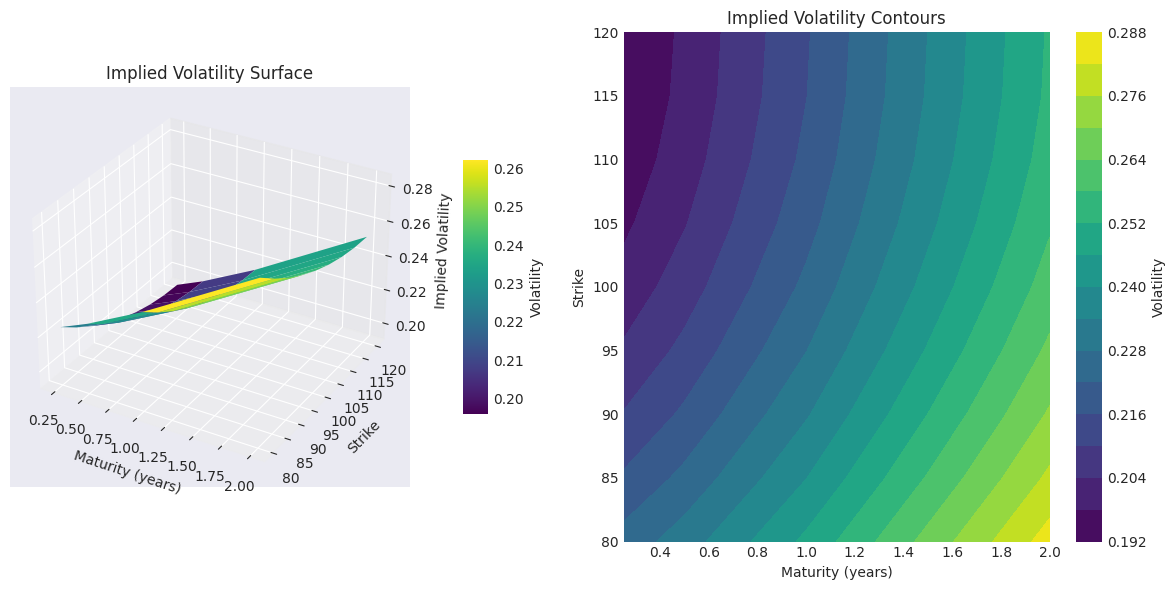

In [5]:
K_grid, T_grid = np.meshgrid(strikes, maturities, indexing="ij")
vol_grid = implied_vols

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection="3d")
surf = ax.plot_surface(T_grid, K_grid, vol_grid, cmap=cm.viridis, linewidth=0, antialiased=True)
ax.set_xlabel("Maturity (years)")
ax.set_ylabel("Strike")
ax.set_zlabel("Implied Volatility")
ax.set_title("Implied Volatility Surface")
fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.1, label="Volatility")

ax2 = fig.add_subplot(122)
contour = ax2.contourf(T_grid, K_grid, vol_grid, levels=15, cmap=cm.viridis)
ax2.set_xlabel("Maturity (years)")
ax2.set_ylabel("Strike")
ax2.set_title("Implied Volatility Contours")
fig.colorbar(contour, ax=ax2, label="Volatility")
plt.tight_layout()
plt.show()

## 5. Query and Interpolate Volatilities

The surface can interpolate implied volatilities for arbitrary strike/maturity pairs.

In [6]:
query_points = [
    (95.0, 0.75),
    (105.0, 1.5),
    (110.0, 0.6),
]
records = []
for strike, maturity in query_points:
    iv = surface.implied_volatility(strike, maturity)
    records.append({"Strike": strike, "Maturity": maturity, "Implied Volatility": iv})
pd.DataFrame(records)

,Strike,Maturity,Implied Volatility
0,95.0,0.75,0.219310
1,105.0,1.50,0.238140
2,110.0,0.60,0.204051


## 6. SABR Calibration

We calibrate a SABR model to a single maturity slice of the surface to obtain a parametric representation of the smile.

In [7]:
target_maturity = 1.0
maturity_index = np.argmin(np.abs(maturities - target_maturity))
smile_strikes = strikes.tolist()
smile_vols = implied_vols[:, maturity_index].tolist()
forward = spot * np.exp((rate - dividend) * target_maturity)
sabr = SABRModel.calibrate(
    forward=forward,
    maturity=target_maturity,
    strikes=smile_strikes,
    market_vols=smile_vols,
    beta=0.6,
)
model_vols = [
    sabr.implied_volatility(forward, float(strike), target_maturity) for strike in smile_strikes
]
comparison = pd.DataFrame(
    {"Strike": smile_strikes, "Market Vol": smile_vols, "SABR Vol": model_vols}
)
comparison

,Strike,Market Vol,SABR Vol
0,80.0,0.247349,0.236624
1,85.0,0.239847,0.233811
2,90.0,0.233347,0.231178
3,95.0,0.227847,0.228704
4,100.0,0.223345,0.226372
5,105.0,0.219847,0.224169
6,110.0,0.217347,0.222080
7,115.0,0.215847,0.220095
8,120.0,0.215345,0.218206


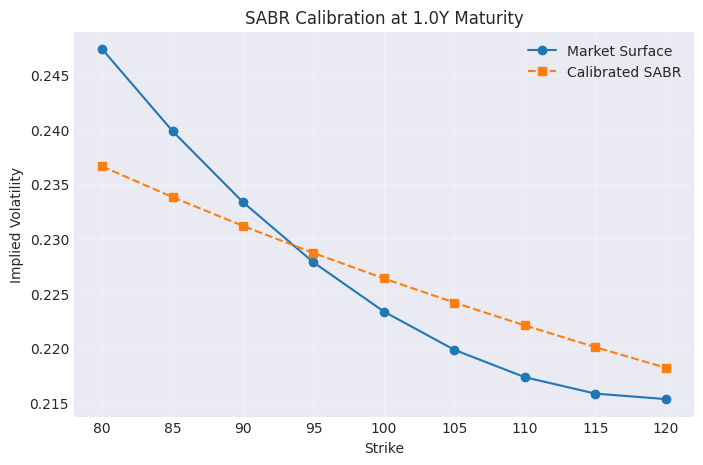

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(smile_strikes, smile_vols, "o-", label="Market Surface")
plt.plot(smile_strikes, model_vols, "s--", label="Calibrated SABR")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title(f"SABR Calibration at {target_maturity:.1f}Y Maturity")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()